# **Decision Tree**

## Inspecting the dataset

In [ ]:
import pandas as pd

file_path = "final_cleaned_oscars.csv"
df = pd.read_csv(file_path)

df.head()

,Year,Category,Film,Film_ID,Nominee,Winner,TMDb_ID,Popularity,Vote_Count,Vote_Average,Genres,Director,IMDb_Rating
0,1972,Best Cinematography,1776,tt0068156,"Harry Stradling, Jr.",False,14902,6.822,75,6.8,"Drama, History, Musical",Peter H. Hunt,7.2
1,2019,Best Cinematography,1917,tt8579674,Roger Deakins,True,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
2,2019,Best Director,1917,tt8579674,Sam Mendes,False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
3,2019,Best Picture,1917,tt8579674,"Sam Mendes, Pippa Harris, Jayne-Ann Tenggren a...",False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
4,2019,Best Original Screenplay,1917,tt8579674,Written by Sam Mendes & Krysty Wilson-Cairns,False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2


## Feature Selection and One-Hot Encoding Categorical Column

In [ ]:
df = df[['IMDb_Rating', 'Popularity', 'Vote_Count', 'Vote_Average', 'Category', 'Winner']]

df['Winner'] = df['Winner'].astype(int)

<ipython-input-2-7297d098d918>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Winner'] = df['Winner'].astype(int)


In [ ]:
df_encoded = pd.get_dummies(df, columns=['Category'])

df_encoded.to_csv('dt_encoded.csv', index=False)

## Splitting data into Training and Testing sets

In [ ]:
X = df_encoded.drop('Winner', axis=1)
y = df_encoded['Winner']

## Train-Test Split (Disjoint Sets)

In [ ]:
from sklearn.model_selection import train_test_split

# Use stratify=y to maintain class balance in split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Saving the datasets

In [ ]:
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_data.to_csv('dt_train_data.csv', index=False)
test_data.to_csv('dt_test_data.csv', index=False)

## Balancing the Training Data Using SMOTE

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Save the balanced training data
df_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
df_train_smote['Winner'] = y_train_smote
df_train_smote.to_csv('train_data_smote_balanced.csv', index=False)

## Training 3 Decision Trees (Different Roots / Depths)

In [33]:
from sklearn.tree import plot_tree

# Feature subset
features_tree_1 = ['IMDb_Rating', 'Vote_Count']

clf_1 = DecisionTreeClassifier(max_depth=3, random_state=1)
clf_1.fit(X_train_smote[features_tree_1], y_train_smote)
y_pred_1 = clf_1.predict(X_test[features_tree_1])

# Evaluation
print("=== Tree 1 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_1))
print("Classification Report:\n", classification_report(y_test, y_pred_1))

=== Tree 1 ===
Accuracy: 0.4866504854368932
Confusion Matrix:
 [[285 380]
 [ 43 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.43      0.57       665
           1       0.23      0.73      0.35       159

    accuracy                           0.49       824
   macro avg       0.55      0.58      0.46       824
weighted avg       0.75      0.49      0.53       824



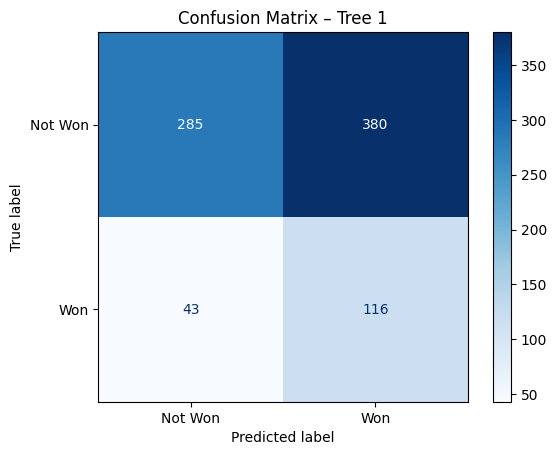

In [34]:
# Confusion Matrix Plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1, display_labels=['Not Won', 'Won'], cmap='Blues')
plt.title("Confusion Matrix – Tree 1")
plt.show()

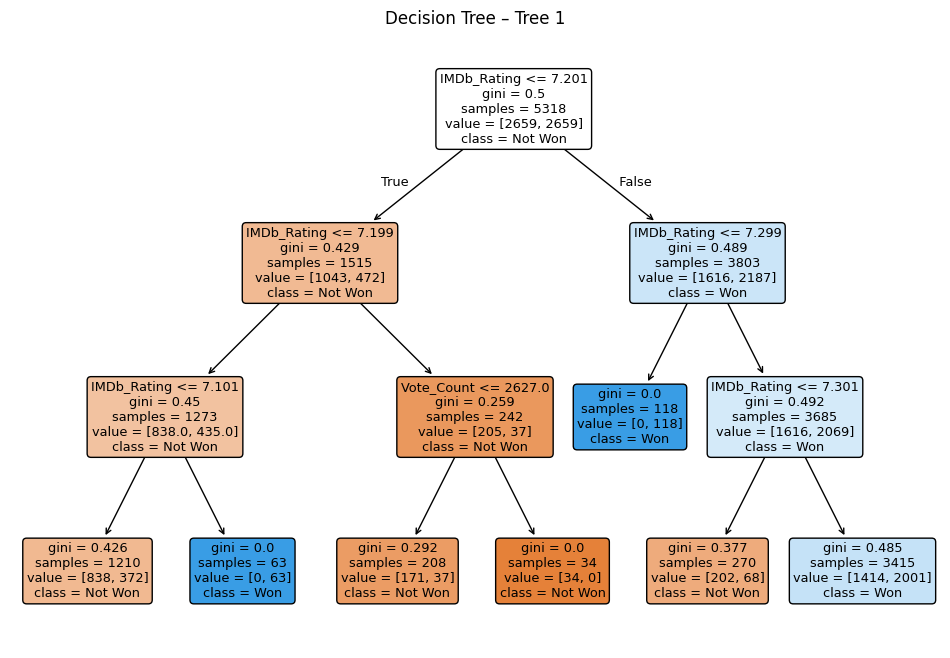

In [36]:
# Tree 1 Visualization
plt.figure(figsize=(12, 8))
plot_tree(clf_1, feature_names=features_tree_1, class_names=['Not Won', 'Won'], filled=True, rounded=True)
plt.title("Decision Tree – Tree 1")
plt.savefig('tree1_structure.png')
plt.show()

## Tree 2 – Popularity & Vote_Average

In [37]:
features_tree_2 = ['Popularity', 'Vote_Average']

clf_2 = DecisionTreeClassifier(max_depth=3, random_state=2)
clf_2.fit(X_train_smote[features_tree_2], y_train_smote)
y_pred_2 = clf_2.predict(X_test[features_tree_2])

print("=== Tree 2 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_2))
print("Classification Report:\n", classification_report(y_test, y_pred_2))

=== Tree 2 ===
Accuracy: 0.5546116504854369
Confusion Matrix:
 [[351 314]
 [ 53 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.53      0.66       665
           1       0.25      0.67      0.37       159

    accuracy                           0.55       824
   macro avg       0.56      0.60      0.51       824
weighted avg       0.75      0.55      0.60       824



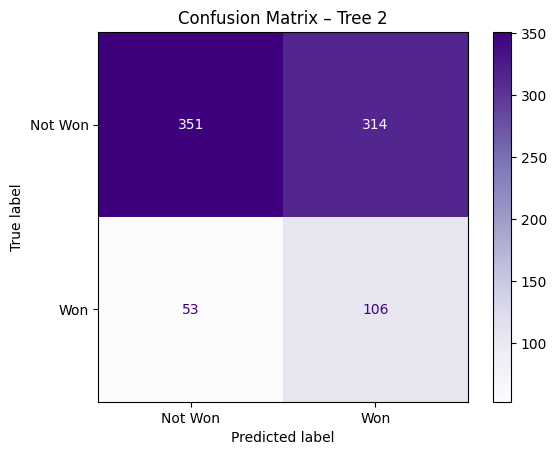

In [38]:
# Confusion Matrix Plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, display_labels=['Not Won', 'Won'], cmap='Purples')
plt.title("Confusion Matrix – Tree 2")
plt.show()

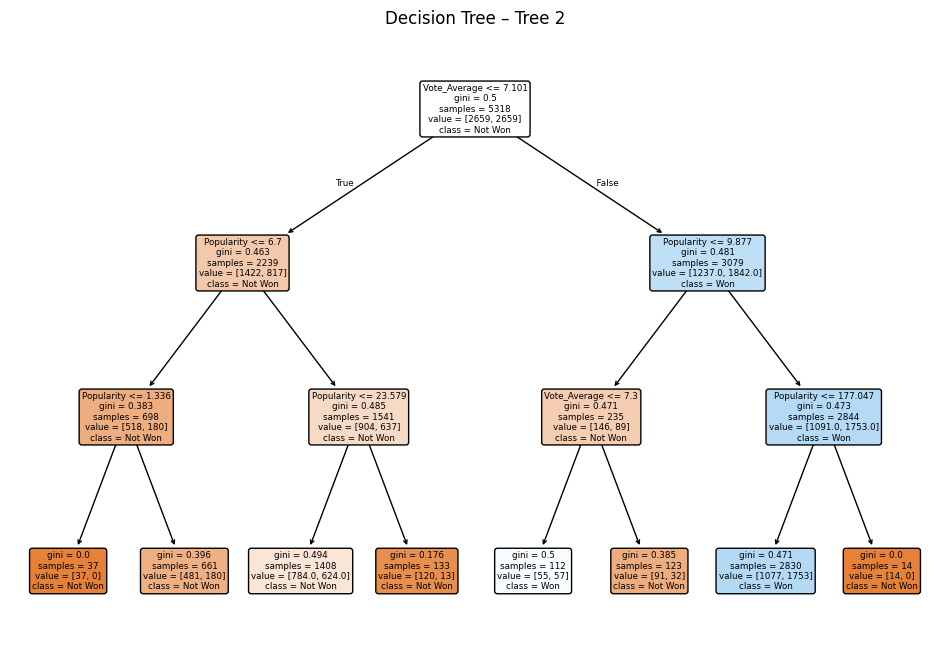

In [40]:
# Tree 2 Visualization
plt.figure(figsize=(12, 8))
plot_tree(clf_2, feature_names=features_tree_2, class_names=['Not Won', 'Won'], filled=True, rounded=True)
plt.title("Decision Tree – Tree 2")
plt.savefig('tree2_structure.png')
plt.show()

## Tree 3 – Vote_Average, Popularity, Vote_Count

In [41]:
features_tree_3 = ['Vote_Average', 'Popularity', 'Vote_Count']

clf_3 = DecisionTreeClassifier(max_depth=3, random_state=3)
clf_3.fit(X_train_smote[features_tree_3], y_train_smote)
y_pred_3 = clf_3.predict(X_test[features_tree_3])

print("=== Tree 3 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_3))
print("Classification Report:\n", classification_report(y_test, y_pred_3))


=== Tree 3 ===
Accuracy: 0.5546116504854369
Confusion Matrix:
 [[351 314]
 [ 53 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.53      0.66       665
           1       0.25      0.67      0.37       159

    accuracy                           0.55       824
   macro avg       0.56      0.60      0.51       824
weighted avg       0.75      0.55      0.60       824



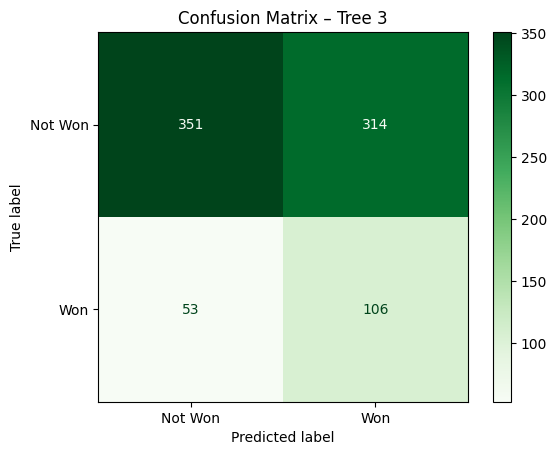

In [42]:
# Confusion Matrix Plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3, display_labels=['Not Won', 'Won'], cmap='Greens')
plt.title("Confusion Matrix – Tree 3")
plt.show()


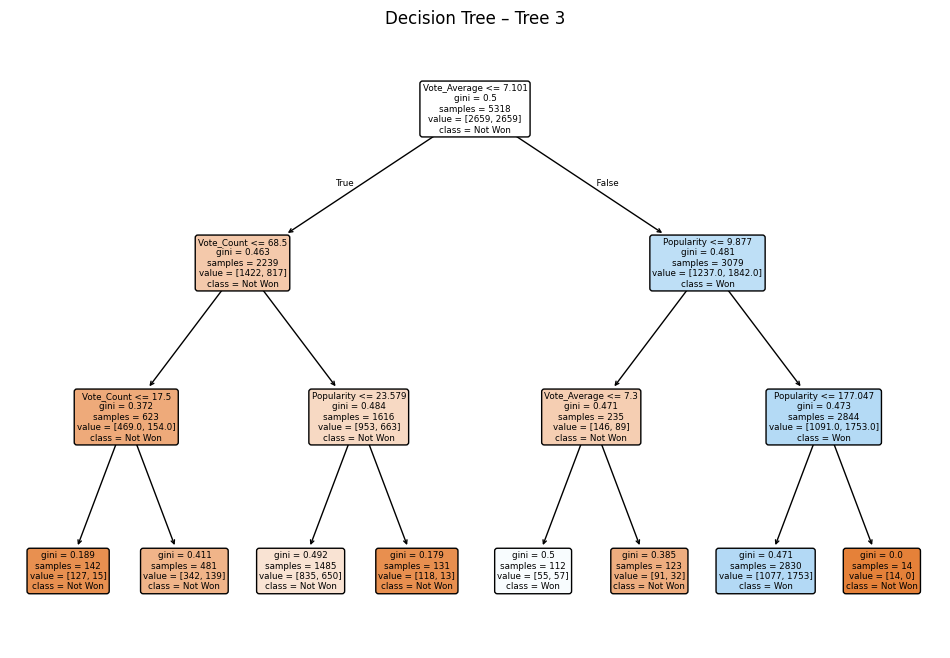

In [45]:
# Tree 3 Visualization
plt.figure(figsize=(12, 8))
plot_tree(clf_3, feature_names=features_tree_3, class_names=['Not Won', 'Won'], filled=True, rounded=True)
plt.title("Decision Tree – Tree 3")
plt.savefig('tree3_structure.png')
plt.show()

## Compariosin of the trees

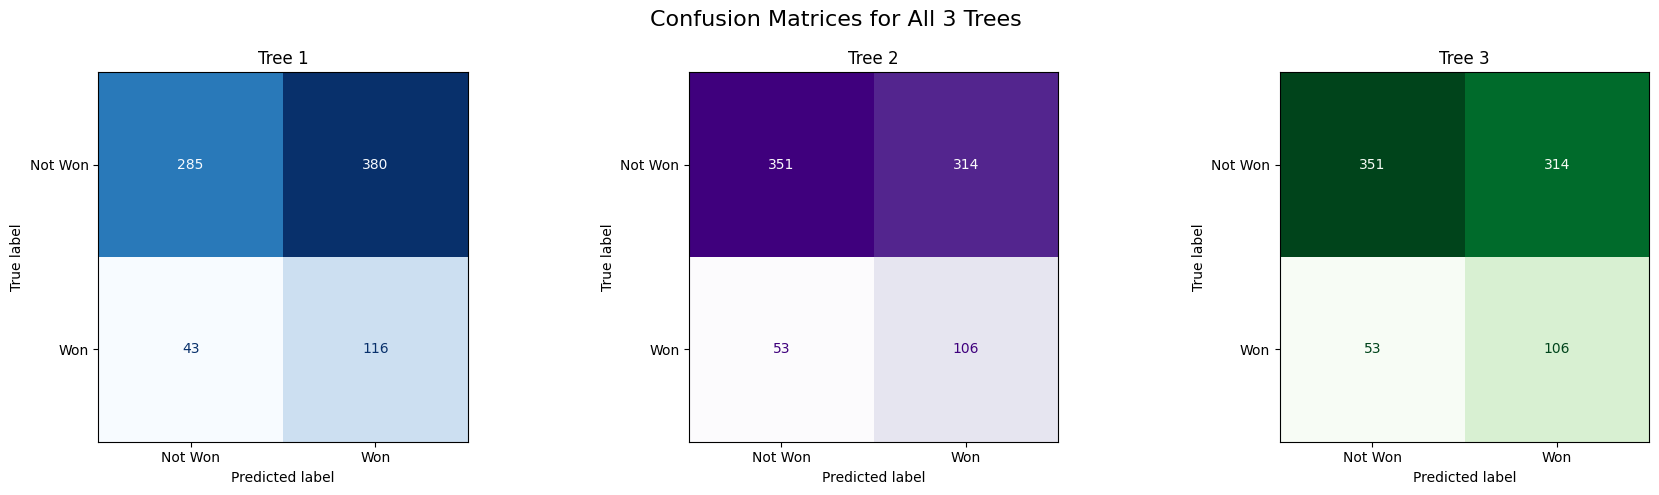

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions for each tree
predictions = [y_pred_1, y_pred_2, y_pred_3]
titles = ['Tree 1', 'Tree 2', 'Tree 3']
colors = ['Blues', 'Purples', 'Greens']

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Confusion Matrices for All 3 Trees", fontsize=16)

for ax, y_pred, title, cmap in zip(axes, predictions, titles, colors):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Not Won', 'Won'], cmap=cmap, ax=ax, colorbar=False
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()